In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# !git clone https://github.com/noreentry/annotated-transformer
import os
os.chdir('/content/annotated-transformer')

In [0]:
# import pydevd_pycharm
# pydevd_pycharm.settrace('10.8.15.6', port=34567, stdoutToServer=True, stderrToServer=True)

In [0]:
# from IPython.display import Image
# Image(filename='images/aiayn.png')

The Transformer from ["Attention is All You Need"](https://arxiv.org/abs/1706.03762) has been on a lot of people's minds over the last year. Besides producing major improvements in translation quality, it provides a new architecture for many other NLP tasks. The paper itself is very clearly written, but the conventional wisdom has been that it is quite difficult to implement correctly. 

In this post I present an "annotated" version of the paper in the form of a line-by-line implementation. I have reordered and deleted some sections from the original paper and added comments throughout. This document itself is a working notebook, and should be a completely usable implementation. In total there are 400 lines of library code which can process 27,000 tokens per second on 4 GPUs. 

To follow along you will first need to install [PyTorch](http://pytorch.org/). The complete notebook is also available on [github](https://github.com/harvardnlp/annotated-transformer) or on Google [Colab](https://drive.google.com/file/d/1xQXSv6mtAOLXxEMi8RvaW8TW-7bvYBDF/view?usp=sharing). 

Note this is merely a starting point for researchers and interested developers. The code here is based heavily on our [OpenNMT](http://opennmt.net) packages. (If helpful feel free to [cite](#conclusion).) For other full-sevice implementations of the model check-out [Tensor2Tensor](https://github.com/tensorflow/tensor2tensor) (tensorflow) and [Sockeye](https://github.com/awslabs/sockeye) (mxnet).

- Alexander Rush ([@harvardnlp](https://twitter.com/harvardnlp) or srush@seas.harvard.edu)


# Prelims

In [0]:
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext seaborn 

In [0]:
# !pip install numpy matplotlib spacy torchtext seaborn 

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.tensorboard
import math, copy, time, itertools
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

import transformer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Table of Contents


* Table of Contents                               
{:toc}      

> My comments are blockquoted. The main text is all from the paper itself.

# Background

The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU, ByteNet and ConvS2S, all of which use convolutional neural networks as basic building block, computing hidden representations in parallel for all input and output positions. In these models, the number of operations required to relate signals from two arbitrary input or output positions grows in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes it more difficult to learn dependencies between distant positions. In the Transformer this is reduced to a constant number of operations, albeit at the cost of reduced effective resolution due to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention.

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations. End-to-end memory networks are based on a recurrent attention mechanism instead of sequencealigned recurrence and have been shown to perform well on simple-language question answering and
language modeling tasks.

To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution. 

# Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure [(cite)](https://arxiv.org/abs/1409.0473). Here, the encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, ..., z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1,...,y_m)$ of symbols one element at a time. At each step the model is auto-regressive [(cite)](https://arxiv.org/abs/1308.0850), consuming the previously generated symbols as additional input when generating the next. 

In [0]:
from transformer import EncoderDecoder

In [0]:
from transformer import Generator

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively. 

In [0]:
# Image(filename='images/ModalNet-21.png')

## Encoder and Decoder Stacks   

### Encoder

The encoder is composed of a stack of $N=6$ identical layers. 

In [0]:
from transformer import clones

In [0]:
from transformer import Encoder

We employ a residual connection [(cite)](https://arxiv.org/abs/1512.03385) around each of the two sub-layers, followed by layer normalization [(cite)](https://arxiv.org/abs/1607.06450).  

In [0]:
from transformer import LayerNorm

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply dropout [(cite)](http://jmlr.org/papers/v15/srivastava14a.html) to the output of each sub-layer, before it is added to the sub-layer input and normalized.  

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.  

In [0]:
from transformer import SublayerConnection

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [0]:
from transformer import EncoderLayer

### Decoder

The decoder is also composed of a stack of $N=6$ identical layers.  

In [0]:
from transformer import Decoder

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack.  Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.  

In [0]:
from transformer import DecoderLayer

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions.  This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

In [0]:
from transformer import subsequent_mask

> Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.

In [0]:
# plt.figure(figsize=(5,5))
# plt.imshow(subsequent_mask(20)[0]);

### Attention                                                                                                                                                                                                                                                                             
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.                                                                                                                                                                                                                                                                                   

We call our particular attention "Scaled Dot-Product Attention".   The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.  We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.                                                                                                                                                                                                                                  
                                                                                                                                                                     

In [0]:
# Image(filename='images/ModalNet-19.png')

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$   

In [0]:
from transformer import attention

The two most commonly used attention functions are additive attention [(cite)](https://arxiv.org/abs/1409.0473), and dot-product (multiplicative) attention.  Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer.  While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.                                                                                             

While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$ [(cite)](https://arxiv.org/abs/1703.03906). We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients  (To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean $0$ and variance $1$.  Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance $d_k$.). To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.          

In [0]:
# Image(filename='images/ModalNet-20.png')

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.                                            
$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                                                                 

Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.                                                                                                                                                                                             In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality. 

In [0]:
from transformer import MultiHeadedAttention

### Applications of Attention in our Model
The Transformer uses multi-head attention in three different ways:                                                        
1) In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder.   This allows every position in the decoder to attend over all positions in the input sequence.  This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as [(cite)](https://arxiv.org/abs/1609.08144).    


2) The encoder contains self-attention layers.  In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder.   Each position in the encoder can attend to all positions in the previous layer of the encoder.                                                   


3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position.  We need to prevent leftward information flow in the decoder to preserve the auto-regressive property.  We implement this inside of scaled dot-product attention by masking out (setting to $-\infty$) all values in the input of the softmax which correspond to illegal connections.                                                                                                                                                                                                                                                      

## Position-wise Feed-Forward Networks                                                                                                                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically.  This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                        
While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.  The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$. 

In [0]:
from transformer import PositionwiseFeedForward

## Embeddings and Softmax                                                                                                                                                                                                                                                                                           
Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{\text{model}}$.  We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities.  In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [(cite)](https://arxiv.org/abs/1608.05859). In the embedding layers, we multiply those weights by $\sqrt{d_{\text{model}}}$.                                                                                                                                 

In [0]:
from transformer import Embeddings

## Positional Encoding                                                                                                                             
Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.  To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.  The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.   There are many choices of positional encodings, learned and fixed [(cite)](https://arxiv.org/pdf/1705.03122.pdf). 

In this work, we use sine and cosine functions of different frequencies:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$                                                                                                                                                                                                                                                        
where $pos$ is the position and $i$ is the dimension.  That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$. 

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.  For the base model, we use a rate of $P_{drop}=0.1$. 
                                                                                                                                                                                                                                                    


In [0]:
from transformer import PositionalEncoding

> Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension. 

In [0]:
# plt.figure(figsize=(15, 5))
# pe = PositionalEncoding(20, 0)
# y = pe.forward(Variable(torch.zeros(1, 100, 20)))
# plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
# plt.legend(["dim %d"%p for p in [4,5,6,7]])
# plt.show()

We also experimented with using learned positional embeddings [(cite)](https://arxiv.org/pdf/1705.03122.pdf) instead, and found that the two versions produced nearly identical results.  We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.    

## Full Model

> Here we define a function from hyperparameters to a full model. 

In [0]:
from transformer import make_model

In [0]:
# Small example model.
tmp_model = make_model(10, 10, 2)

# Training

This section describes the training regime for our models.

> We stop for a quick interlude to introduce some of the tools 
needed to train a standard encoder decoder model. First we define a batch object that holds the src and target sentences for training, as well as constructing the masks. 

## Batches and Masking

In [0]:
from transformer import Batch

> Next we create a generic training and scoring function to keep track of loss. We pass in a generic loss compute function that also handles parameter updates. 

## Training Loop

In [0]:
from transformer import run_epoch

## Training Data and Batching

We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs.  Sentences were encoded using byte-pair encoding, which has a shared source-target vocabulary of about 37000 tokens. For English-French, we used the significantly larger WMT 2014 English-French dataset consisting of 36M sentences and split tokens into a 32000 word-piece vocabulary.

Sentence pairs were batched together by approximate sequence length.  Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens.

> We will use torch text for batching. This is discussed in more detail below. Here we create batches in a torchtext function that ensures our batch size padded to the maximum batchsize does not surpass a threshold (25000 if we have 8 gpus).

In [0]:
from transformer import batch_size_fn

## Hardware and Schedule                                                                                                                                                                                                   
We trained our models on one machine with 8 NVIDIA P100 GPUs.  For our base models using the hyperparameters described throughout the paper, each training step took about 0.4 seconds.  We trained the base models for a total of 100,000 steps or 12 hours. For our big models, step time was 1.0 seconds.  The big models were trained for 300,000 steps (3.5 days).

## Optimizer

We used the Adam optimizer [(cite)](https://arxiv.org/abs/1412.6980) with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$.  We varied the learning rate over the course of training, according to the formula:                                                                                            
$$                                                                                                                                                                                                                                                                                         
lrate = d_{\text{model}}^{-0.5} \cdot                                                                                                                                                                                                                                                                                                
  \min({step\_num}^{-0.5},                                                                                                                                                                                                                                                                                                  
    {step\_num} \cdot {warmup\_steps}^{-1.5})                                                                                                                                                                                                                                                                               
$$                                                                                                                                                                                             
This corresponds to increasing the learning rate linearly for the first $warmup\_steps$ training steps, and decreasing it thereafter proportionally to the inverse square root of the step number.  We used $warmup\_steps=4000$.                            

> Note: This part is very important. Need to train with this setup of the model. 

In [0]:
from transformer import NoamOpt, get_std_opt

> Example of the curves of this model for different model sizes and for optimization hyperparameters. 

In [0]:
# # Three settings of the lrate hyperparameters.
# opts = [NoamOpt(512, 1, 4000, None), 
#         NoamOpt(512, 1, 8000, None),
#         NoamOpt(256, 1, 4000, None)]
# plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
# plt.legend(["512:4000", "512:8000", "256:4000"])
# plt.show()

## Regularization                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                                                                                                      
### Label Smoothing

During training, we employed label smoothing of value $\epsilon_{ls}=0.1$ [(cite)](https://arxiv.org/abs/1512.00567).  This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.  

> We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has `confidence` of the correct word and the rest of the `smoothing` mass distributed throughout the vocabulary.

In [0]:
from transformer import LabelSmoothing

> Here we can see an example of how the mass is distributed to the words based on confidence. 

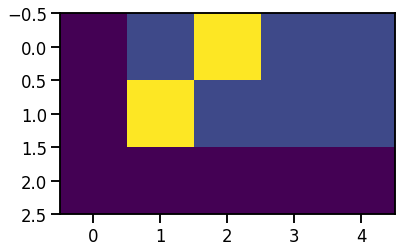

In [87]:
#Example of label smoothing.
if False:
    crit = LabelSmoothing(5, 0, 0.4)
    predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                                [0, 0.2, 0.7, 0.1, 0], 
                                [0, 0.2, 0.7, 0.1, 0]])
    v = crit(Variable(predict.log()), Variable(torch.LongTensor([2, 1, 0])))

    # Show the target distributions expected by the system.
    plt.imshow(crit.true_dist);

> Label smoothing actually starts to penalize the model if it gets very confident about a given choice. 

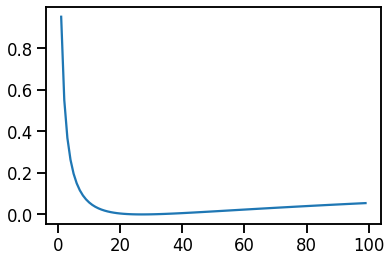

In [88]:
if False:
    crit = LabelSmoothing(5, 0, 0.1)
    def loss(x):
        d = x + 3 * 1
        predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    #     print(predict)
        return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).item()
    plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
    plt.show()

# A First  Example

> We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols. 

## Synthetic Data

In [0]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [0]:
# b = list(data_gen(11, 2, 1))[0]

## Loss Computation

In [0]:
from transformer import SimpleLossCompute

## Greedy Decoding

In [0]:
# Train the simple copy task.
if False:
    from transformer import run_epoch

    V = 11
    criterion = transformer.LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = transformer.make_model(V, V, N=2)
    model_opt = transformer.NoamOpt(model.src_embed[0].d_model, 1, 400, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    writer = torch.utils.tensorboard.SummaryWriter()
    for epoch in range(10):
        model.train()
        transformer.run_epoch(data_gen(V, 50, 20), model, SimpleLossCompute(model.generator, criterion, model_opt), writer=writer, writer_step0=epoch*20)
        model.eval()
        print(f'epoch {epoch}: loss/token {transformer.run_epoch(data_gen(V, 30, 5), model, SimpleLossCompute(model.generator, criterion, None)):.6f}')    
    writer.close()

> This code predicts a translation using greedy decoding for simplicity. 

In [0]:
from transformer import greedy_decode

In [0]:
if False:
    model.eval()
    src = Variable(torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]))
    src_mask = Variable(torch.ones(1, 1, 10))
    print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

# A Real World Example

> Now we consider a real-world example using the IWSLT German-English Translation task. This task is much smaller than the WMT task considered in the paper, but it illustrates the whole system. We also show how to use multi-gpu processing to make it really fast.

In [95]:
!pip install torchtext spacy
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


## Data Loading
> We will load the dataset using torchtext and spacy for tokenization. 

In [0]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, eos_token = EOS_WORD, pad_token=BLANK_WORD)

    MAX_LEN = 100
    train, valid, test = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TGT), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 2
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

> Batching matters a ton for speed. We want to have very evenly divided batches, with absolutely minimal padding. To do this we have to hack a bit around the default torchtext batching. This code patches their default batching to make sure we search over enough sentences to find tight batches. 

## Iterators

In [0]:
# from transformer import MyIterator

def rebatch(batch, pad_idx):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return transformer.Batch(src, trg, pad_idx)

## Multi-GPU Training

> Finally to really target fast training, we will use multi-gpu. This code implements multi-gpu word generation. It is not specific to transformer so I won't go into too much detail. The idea is to split up word generation at training time into chunks to be processed in parallel across many different gpus. We do this using pytorch parallel primitives:

* replicate - split modules onto different gpus.
* scatter - split batches onto different gpus
* parallel_apply - apply module to batches on different gpus
* gather - pull scattered data back onto one gpu. 
* nn.DataParallel - a special module wrapper that calls these all before evaluating. 


In [0]:
# from transformer import MultiGPULossCompute

> Now we create our model, criterion, optimizer, data iterators, and paralelization

In [ ]:
# GPUs to use
devices = [0, 1, 2, 3]
if False:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 12000
    train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)
    model_par = nn.DataParallel(model, device_ids=devices)

> Now we train the model. I will play with the warmup steps a bit, but everything else uses the default parameters.  On an AWS p3.8xlarge with 4 Tesla V100s, this runs at ~27,000 tokens per second with a batch size of 12,000 

## Training the System

In [ ]:
#!wget https://s3.amazonaws.com/opennmt-models/iwslt.pt

In [ ]:
# train on CPU
if False:
    EPOCHS, BATCH_SIZE = 2, 2000
    pad_idx    = TGT.vocab.stoi["<blank>"]
    model      = transformer.make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    crit       = transformer.LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    train_iter = transformer.MyIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: (len(x.src), len(x.trg)),
                                        batch_size_fn=transformer.batch_size_fn, train=True,  repeat=False)
    valid_iter = transformer.MyIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: (len(x.src), len(x.trg)),
                                        batch_size_fn=transformer.batch_size_fn, train=False, repeat=False)
    
    writer, step0 = torch.utils.tensorboard.SummaryWriter(flush_secs=15), 0
    model_opt = transformer.NoamOpt(model.src_embed[0].d_model, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(EPOCHS):
        print(f'epoch {epoch}:')
        model.train()
        loss, nbatches, nitems, ntokens = transformer.run_epoch((rebatch(b, pad_idx) for b in itertools.islice(train_iter, 10)), model,
                                                                SimpleLossCompute(model.generator, crit, model_opt), writer=writer, writer_step0=step0)
        step0 += nbatches
        
        model.eval()
        loss, nbatches, nitems, ntokens = transformer.run_epoch((rebatch(b, pad_idx) for b in itertools.islice(valid_iter, 10)), model,
                                                                SimpleLossCompute(model.generator, crit, model_opt))
        print(f'  ----           {loss/ntokens:.6f} loss/token, {ntokens/nitems:>4.1f} tokens/item')    
    writer.close()
else:
    model = torch.load("iwslt.pt", map_location=torch.device('cpu'))

In [ ]:
import gc
gc.collect()

In [ ]:

# Skip if not interested in multigpu.
class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."

    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        # Send out to different gpus.
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size

    def __call__(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator, devices=self.devices)
        out_scatter = nn.parallel.scatter(out, target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets, target_gpus=self.devices)

        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # Predict distributions
            out_column = [[Variable(o[:, i:i + chunk_size].data, requires_grad=self.opt is not None)] for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # Compute loss.
            y = [(g.contiguous().view(-1, g.size(-1)), t[:, i:i + chunk_size].contiguous().view(-1)) for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # Sum and normalize loss
            l = nn.parallel.gather(loss, target_device=self.devices[0])
            if i == 0: print(l.shape)
            l = l.sum() / normalize
            total += l.data.item()

            # Backprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # Backprop all loss through transformer.
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

In [ ]:
!nvidia-smi

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
!ps -aux|grep python

In [ ]:
!kill -9 124

In [ ]:
!nvidia-smi

In [ ]:
if True:
    # GPUs to use
    devices = [0]
    EPOCHS, BATCH_SIZE = 2, 3000
    pad_idx    = TGT.vocab.stoi["<blank>"]
    model      = transformer.make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    crit       = transformer.LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    train_iter = transformer.MyIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: (len(x.src), len(x.trg)), device='cuda',
                                        batch_size_fn=transformer.batch_size_fn, train=True,  repeat=False)
    valid_iter = transformer.MyIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: (len(x.src), len(x.trg)), device='cuda',
                                        batch_size_fn=transformer.batch_size_fn, train=False, repeat=False)
    model.cuda()
    crit.cuda()
    # model_par = nn.DataParallel(model, device_ids=devices)

In [ ]:
!nvidia-smi

In [ ]:
# GPU training
if True:
    # # GPUs to use
    # devices = [0]
    # EPOCHS, BATCH_SIZE = 2, 20
    # pad_idx    = TGT.vocab.stoi["<blank>"]
    # model      = transformer.make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    # crit       = transformer.LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    # train_iter = transformer.MyIterator(islice(train, 10000), batch_size=BATCH_SIZE, sort_key=lambda x: (len(x.src), len(x.trg)), device='cuda',
    #                                     batch_size_fn=transformer.batch_size_fn, train=True,  repeat=False)
    # valid_iter = transformer.MyIterator(islice(valid, 10000), batch_size=BATCH_SIZE, sort_key=lambda x: (len(x.src), len(x.trg)), device='cuda',
    #                                     batch_size_fn=transformer.batch_size_fn, train=False, repeat=False)
    # model.cuda()
    # crit.cuda()
    model_par = nn.DataParallel(model, device_ids=devices)
    model_trn = model_par

    writer, step0 = torch.utils.tensorboard.SummaryWriter(flush_secs=15), 0
    model_opt = transformer.NoamOpt(model.src_embed[0].d_model, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(EPOCHS):
        print(f'epoch {epoch}:')
        model_trn.train()
        loss, nbatches, nitems, ntokens = transformer.run_epoch((rebatch(b, pad_idx) for b in itertools.islice(train_iter, 10)), model_trn,
                                                                # transformer.SimpleLossCompute(model.generator, crit, model_opt),
                                                                MultiGPULossCompute(model.generator, crit, devices=devices, opt=model_opt),
                                                                writer=writer, writer_step0=step0)
        step0 += nbatches
        
        model_trn.eval()
        loss, nbatches, nitems, ntokens = transformer.run_epoch((rebatch(b, pad_idx) for b in itertools.islice(valid_iter, 10)), model_trn,
                                                                # transformer.SimpleLossCompute(model.generator, crit, opt=None),
                                                                MultiGPULossCompute(model.generator, crit, devices=devices, opt=None)
                                                                )
        print(f'  ----           {loss/ntokens:.6f} loss/token, {ntokens/nitems:>4.1f} tokens/item')    
    writer.close()

else:
#     model = torch.load("iwslt.pt"
    model = torch.load("iwslt.pt", map_location=torch.device('cpu'))

In [ ]:
!nvidia-smi

> Once trained we can decode the model to produce a set of translations. Here we simply translate the first sentence in the validation set. This dataset is pretty small so the translations with greedy search are reasonably accurate. 

In [0]:
# GPUs to use
devices = [0, 1, 2, 3]
if False:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 12000
    train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)
    model_par = nn.DataParallel(model, device_ids=devices)

> Now we train the model. I will play with the warmup steps a bit, but everything else uses the default parameters.  On an AWS p3.8xlarge with 4 Tesla V100s, this runs at ~27,000 tokens per second with a batch size of 12,000 

## Training the System

In [0]:
#!wget https://s3.amazonaws.com/opennmt-models/iwslt.pt

In [49]:
# train on CPU
if False:
    EPOCHS, BATCH_SIZE = 2, 2000
    pad_idx    = TGT.vocab.stoi["<blank>"]
    model      = transformer.make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    crit       = transformer.LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    train_iter = transformer.MyIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: (len(x.src), len(x.trg)),
                                        batch_size_fn=transformer.batch_size_fn, train=True,  repeat=False)
    valid_iter = transformer.MyIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: (len(x.src), len(x.trg)),
                                        batch_size_fn=transformer.batch_size_fn, train=False, repeat=False)
    
    writer, step0 = torch.utils.tensorboard.SummaryWriter(flush_secs=15), 0
    model_opt = transformer.NoamOpt(model.src_embed[0].d_model, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(EPOCHS):
        print(f'epoch {epoch}:')
        model.train()
        loss, nbatches, nitems, ntokens = transformer.run_epoch((rebatch(b, pad_idx) for b in itertools.islice(train_iter, 10)), model,
                                                                SimpleLossCompute(model.generator, crit, model_opt), writer=writer, writer_step0=step0)
        step0 += nbatches
        
        model.eval()
        loss, nbatches, nitems, ntokens = transformer.run_epoch((rebatch(b, pad_idx) for b in itertools.islice(valid_iter, 10)), model,
                                                                SimpleLossCompute(model.generator, crit, model_opt))
        print(f'  ----           {loss/ntokens:.6f} loss/token, {ntokens/nitems:>4.1f} tokens/item')    
    writer.close()
else:
    model = torch.load("iwslt.pt", map_location=torch.device('cpu'))

epoch 0:
      400 items  9.314434 loss/token, 14.0 tokens/item,   133 items/batch,   115.4711 tokens/sec, 
      840 items  9.272344 loss/token, 13.0 tokens/item,   133 items/batch,   121.3874 tokens/sec, 
  ----           9.109903 loss/token, 16.0 tokens/item
epoch 1:
      386 items  9.042660 loss/token, 61.0 tokens/item,    23 items/batch,   114.3104 tokens/sec, 
      735 items  8.976195 loss/token, 15.0 tokens/item,   125 items/batch,   124.9413 tokens/sec, 
  ----           8.795416 loss/token, 16.0 tokens/item


In [99]:
import gc
gc.collect()

0

In [0]:

# Skip if not interested in multigpu.
class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."

    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        # Send out to different gpus.
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size

    def __call__(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator, devices=self.devices)
        out_scatter = nn.parallel.scatter(out, target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets, target_gpus=self.devices)

        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # Predict distributions
            out_column = [[Variable(o[:, i:i + chunk_size].data, requires_grad=self.opt is not None)] for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # Compute loss.
            y = [(g.contiguous().view(-1, g.size(-1)), t[:, i:i + chunk_size].contiguous().view(-1)) for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # Sum and normalize loss
            l = nn.parallel.gather(loss, target_device=self.devices[0])
            if i == 0: print(l.shape)
            l = l.sum() / normalize
            total += l.data.item()

            # Backprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # Backprop all loss through transformer.
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

In [62]:
!nvidia-smi

Mon Jun  8 19:55:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    33W /  70W |  10815MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [63]:
import gc
torch.cuda.empty_cache()
gc.collect()

7

In [64]:
!ps -aux|grep python

root          19  0.1  0.7 413532 103696 ?       Sl   17:36   0:13 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root         839  5.6 44.8 28048048 5978588 ?    Ssl  18:46   3:51 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-4e824ed1-bcf1-4a4d-8595-bb47c0a67ebe.json
root        2061  0.0  0.0  39196  6364 ?        S    19:55   0:00 /bin/bash -c ps -aux|grep python
root        2063  0.0  0.0  38568  4988 ?        S    19:55   0:00 grep python


In [0]:
!kill -9 124

In [56]:
!nvidia-smi

Mon Jun  8 19:41:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    33W /  70W |   5967MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
if True:
    # GPUs to use
    devices = [0]
    EPOCHS, BATCH_SIZE = 2, 3000
    pad_idx    = TGT.vocab.stoi["<blank>"]
    model      = transformer.make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    crit       = transformer.LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    train_iter = transformer.MyIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: (len(x.src), len(x.trg)), device='cuda',
                                        batch_size_fn=transformer.batch_size_fn, train=True,  repeat=False)
    valid_iter = transformer.MyIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: (len(x.src), len(x.trg)), device='cuda',
                                        batch_size_fn=transformer.batch_size_fn, train=False, repeat=False)
    model.cuda()
    crit.cuda()
    # model_par = nn.DataParallel(model, device_ids=devices)

In [66]:
!nvidia-smi

Mon Jun  8 19:55:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    33W /  70W |   6275MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [67]:
# GPU training
if True:
    # # GPUs to use
    # devices = [0]
    # EPOCHS, BATCH_SIZE = 2, 20
    # pad_idx    = TGT.vocab.stoi["<blank>"]
    # model      = transformer.make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    # crit       = transformer.LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    # train_iter = transformer.MyIterator(islice(train, 10000), batch_size=BATCH_SIZE, sort_key=lambda x: (len(x.src), len(x.trg)), device='cuda',
    #                                     batch_size_fn=transformer.batch_size_fn, train=True,  repeat=False)
    # valid_iter = transformer.MyIterator(islice(valid, 10000), batch_size=BATCH_SIZE, sort_key=lambda x: (len(x.src), len(x.trg)), device='cuda',
    #                                     batch_size_fn=transformer.batch_size_fn, train=False, repeat=False)
    # model.cuda()
    # crit.cuda()
    model_par = nn.DataParallel(model, device_ids=devices)
    model_trn = model_par

    writer, step0 = torch.utils.tensorboard.SummaryWriter(flush_secs=15), 0
    model_opt = transformer.NoamOpt(model.src_embed[0].d_model, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(EPOCHS):
        print(f'epoch {epoch}:')
        model_trn.train()
        loss, nbatches, nitems, ntokens = transformer.run_epoch((rebatch(b, pad_idx) for b in itertools.islice(train_iter, 10)), model_trn,
                                                                # transformer.SimpleLossCompute(model.generator, crit, model_opt),
                                                                MultiGPULossCompute(model.generator, crit, devices=devices, opt=model_opt),
                                                                writer=writer, writer_step0=step0)
        step0 += nbatches
        
        model_trn.eval()
        loss, nbatches, nitems, ntokens = transformer.run_epoch((rebatch(b, pad_idx) for b in itertools.islice(valid_iter, 10)), model_trn,
                                                                # transformer.SimpleLossCompute(model.generator, crit, opt=None),
                                                                MultiGPULossCompute(model.generator, crit, devices=devices, opt=None)
                                                                )
        print(f'  ----           {loss/ntokens:.6f} loss/token, {ntokens/nitems:>4.1f} tokens/item')    
    writer.close()

else:
#     model = torch.load("iwslt.pt"
    model = torch.load("iwslt.pt", map_location=torch.device('cpu'))

epoch 0:


/usr/local/lib/python3.6/dist-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
      634 items  9.121724 loss/token, 33.0 tokens/item,    81 items/batch,  3674.9104 tokens/sec, 
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
     1155 items  9.087993 loss/token, 18.0 tokens/item,   150 items/batch,  5706.9668 tokens/sec, 
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
  ----           9.038759 loss/token, 20.0 tokens/item
epoch 1:
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
      447 items  9.016766 loss/token, 18.0 tokens/item,   157 items/batch,  3775.8904 tokens/sec, 
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
      862 items  8.938869 loss/token, 64.0 tokens/item,    29 items/batch,  5324.3037 tokens/sec, 
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([

In [44]:
!nvidia-smi

Mon Jun  8 19:38:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   79C    P0    47W /  70W |   9389MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

> Once trained we can decode the model to produce a set of translations. Here we simply translate the first sentence in the validation set. This dataset is pretty small so the translations with greedy search are reasonably accurate. 

In [0]:
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    break

# Additional Components: BPE, Search, Averaging

> So this mostly covers the transformer model itself. There are four aspects that we didn't cover explicitly. We also have all these additional features implemented in [OpenNMT-py](https://github.com/opennmt/opennmt-py).



> 1) BPE/ Word-piece: We can use a library to first preprocess the data into subword units. See Rico Sennrich's [subword-nmt](https://github.com/rsennrich/subword-nmt) implementation. These models will transform the training data to look like this:

▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden .

> 2) Shared Embeddings: When using BPE with shared vocabulary we can share the same weight vectors between the source / target / generator. See the [(cite)](https://arxiv.org/abs/1608.05859) for details. To add this to the model simply do this:

In [0]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embeddings[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight

> 3) Beam Search: This is a bit too complicated to cover here. See the [OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/translate/Beam.py) for a pytorch implementation.



> 4) Model Averaging: The paper averages the last k checkpoints to create an ensembling effect. We can do this after the fact if we have a bunch of models:

In [0]:
def average(model, models):
    "Average models into model"
    for ps in zip(*[m.params() for m in [model] + models]):
        p[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

# Results

On the WMT 2014 English-to-German translation task, the big transformer model (Transformer (big)
in Table 2) outperforms the best previously reported models (including ensembles) by more than 2.0
BLEU, establishing a new state-of-the-art BLEU score of 28.4. The configuration of this model is
listed in the bottom line of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base model
surpasses all previously published models and ensembles, at a fraction of the training cost of any of
the competitive models.

On the WMT 2014 English-to-French translation task, our big model achieves a BLEU score of 41.0,
outperforming all of the previously published single models, at less than 1/4 the training cost of the
previous state-of-the-art model. The Transformer (big) model trained for English-to-French used
dropout rate Pdrop = 0.1, instead of 0.3.



In [0]:
Image(filename="images/results.png")

> The code we have written here is a version of the base model. There are fully trained version of this system available here  [(Example Models)](http://opennmt.net/Models-py/).
>
> With the addtional extensions in the last section, the OpenNMT-py replication gets to 26.9 on EN-DE WMT. Here I have loaded in those parameters to our reimplemenation. 

In [0]:
!wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt

In [0]:
model, SRC, TGT = torch.load("en-de-model.pt")

In [0]:
model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

## Attention Visualization

> Even with a greedy decoder the translation looks pretty good. We can further visualize it to see what is happening at each layer of the attention 

In [0]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()


# Conclusion

> Hopefully this code is useful for future research. Please reach out if you have any issues. If you find this code helpful, also check out our other OpenNMT tools.

```
@inproceedings{opennmt,
  author    = {Guillaume Klein and
               Yoon Kim and
               Yuntian Deng and
               Jean Senellart and
               Alexander M. Rush},
  title     = {OpenNMT: Open-Source Toolkit for Neural Machine Translation},
  booktitle = {Proc. ACL},
  year      = {2017},
  url       = {https://doi.org/10.18653/v1/P17-4012},
  doi       = {10.18653/v1/P17-4012}
}
```

> Cheers,
> srush

{::options parse_block_html="true" /}
<div id="disqus_thread"></div>
<script>

/**
*  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
*  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables*/
/*
var disqus_config = function () {
this.page.url = PAGE_URL;  // Replace PAGE_URL with your page's canonical URL variable
this.page.identifier = PAGE_IDENTIFIER; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
};
*/
(function() { // DON'T EDIT BELOW THIS LINE
var d = document, s = d.createElement('script');
s.src = 'https://harvard-nlp.disqus.com/embed.js';
s.setAttribute('data-timestamp', +new Date());
(d.head || d.body).appendChild(s);
})();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript">comments powered by Disqus.</a></noscript>
                            

<div id="disqus_thread"></div>
<script>
    /**
     *  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
     *  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
     */
    /*
    var disqus_config = function () {
        this.page.url = PAGE_URL;  // Replace PAGE_URL with your page's canonical URL variable
        this.page.identifier = PAGE_IDENTIFIER; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
    };
    */
    (function() {  // REQUIRED CONFIGURATION VARIABLE: EDIT THE SHORTNAME BELOW
        var d = document, s = d.createElement('script');
        
        s.src = 'https://EXAMPLE.disqus.com/embed.js';  // IMPORTANT: Replace EXAMPLE with your forum shortname!
        
        s.setAttribute('data-timestamp', +new Date());
        (d.head || d.body).appendChild(s);
    })();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript" rel="nofollow">comments powered by Disqus.</a></noscript>